# Universidade Federal de Alagoas - Instituto de Computação
## **4ª lista de exercícios**


---

Alunos: Anderson Clemente

In [ ]:
import numpy as np
import cv2
import time
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from google.colab.patches import cv2_imshow
from IPython.display import clear_output, HTML
from base64 import b64encode
import torch
from IPython.display import Image, clear_output  # to display images

3. Usando a plataforma Kaggle, pesquise um base supervisionada de imagens que possa ser usada para treinar um classificador binário de imagens. Esta base deve conter exemplos de duas classes. Considere 70% das amostras para treino, e 30% para teste (método holdout).

a) Usando OpenCV, extraia descritores HOG (Histogram of Gradients), e treine um classificador SVM. Exiba a acurácia atingida no conjunto de teste e a matriz de confusão. Exiba exemplos. Obs.: note que essa abordagem é semelhante ao detector Dalal-Triggs, porém aqui estamos usando-a para classificação de imagens.

b) Agora o objetivo é treinar uma CNN. Usando a abordagem de
transfeência de aprendizado (transfer learning), realize treinamentos usando modelos VGG16, ResNet50, e MobileNetV2 pré-treinados. Compare os resultados usando acurácias e matrizes de confusão. Exiba exemplos.

4. O objetivo dessa questão é criar um contador de veículos em vídeos de uma rodovia. Você deve experimentar um modelo pré-treinado da YOLO v5, e um Single Shot MultiBox Detection (SSD).

a) Estude a SSD, e descreva suas principais diferenças em relação a YOLO v5.

b) Para cada um dos dois modelos, realize as detecções de veículos em cada frame do vídeo em anexo (classroom). Gere os vídeos com as bounding boxes detectadas.

c) Para cada um dos dois modelos, plote um gráfico onde o eixo horizontal é o tempo (quadro do vídeo), e o vertical é a quantidade de carros detectada pelo modelo.

**a)** A SSD e o YOLO são duas abordagens de redes neurais convolucionais profundas para detecção de objetos em imagens amplamente utilizados. As principais diferenças entre as duas arquiteturas são: O SSD utiliza multiplas caixas delimitadoras para detectar os objetos em diferentes aspectos e escalas, enquanto o YOLO utiliza uma unica caixa para cada objeto, desse modo o YOLO é mais rápido do que o SSD, por outro lado, o SSD tem maior precisão que o YOLO. O SSD tem menor capacidade de generalização devido ao volume de treinamento do YOLO ser maior, consequentemente, o SSD tem um treinamento mais simples que do que o YOLO.



In [ ]:
!pip install yolov5

In [ ]:
!git clone https://github.com/changsin/DLTrafficCounter

Cloning into 'DLTrafficCounter'...
remote: Enumerating objects: 277, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 277 (delta 17), reused 66 (delta 15), pack-reused 209
Receiving objects: 100% (277/277), 226.60 MiB | 15.99 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Updating files: 100% (205/205), done.


In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt  # install dependencies

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 2.0.1+cu118 (CPU)


In [ ]:
!wget https://github.com/ultralytics/yolov5/releases/download/v5.0/yolov5s.pt

In [ ]:
!python detect.py --weights runs/train/exp/weights/best.pt --img 640 --conf 0.5 --source ../DLTrafficCounter/data/bbox_highway/test

In [ ]:
!python detect.py --weights ../DLTrafficCounter/models/yolov5s_highway.pt --img 640 --conf 0.5 --source ../DLTrafficCounter/data/bbox_highway/test

In [ ]:
%cd yolov5

In [ ]:
# !python train.py --img 640 --batch 10  --epochs 400 --data ../DLTrafficCounter/configs/train_traffic_counter.yaml --cfg models/yolov5s.yaml --weights yolov5s.pt --cache

In [ ]:
import yolov5

In [ ]:
def dict_increment(dict1, key):
  if key in dict1.keys():
    dict1[key] = dict1[key] + 1 
  else:
    dict1[key] = 1

  return dict1
  
def print_class_counts(dict1, class_names):
  # print counts for each class name
  for key, val in dict1.items():
    print(class_names[key], val)

def count_vehicles(detection_res, confidence_threshold=0.5):
  counts = dict()
  # print(res.names.index('car'), res.names.index('bus'), res.names.index('truck'))

  for pred in detection_res.xyxyn[0]:
    confidence = pred[-2]
    if confidence > confidence_threshold:
      # print(pred)

      class_id = int(pred[-1])
      counts = dict_increment(counts, class_id)

  print_class_counts(counts, detection_res.names)
  return counts

In [ ]:
# url = "https://youtu.be/pUcWdJoAuyw"

model_highway = yolov5.load('/content/DLTrafficCounter/models/yolov5s_highway.pt')

video_path = '/content/bridge.mp4'

# mp4 = open(video_path, "rb").read()
# data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
# HTML(f"""<video width=400 controls><source src="{data_url}" type="video/mp4"></video>""")
capture = cv2.VideoCapture('/content/bridge.mp4')
counts = []  # List to store the counts of detected vehicles
timestamps = []  # List to store the timestamps or frame numbers
car_count = 0  # Variable to store the count of cars
truck_count = 0  # Variable to store the count of trucks

w = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('/content/output_yolov5s.mp4', fourcc, 24, (w, h))

while True:
  grabbed, frame = capture.read()
  if not grabbed:
        break
  detected = model_highway(frame)
  detected.save("results")

  clear_output(wait=True)
  # count_vehicles(detected)
  count = count_vehicles(detected)
  car_count += count.get(0, 0)  # Increment the car count
  truck_count += count.get(2, 0)  # Increment the truck count
  counts.append(count.get(0, 0))  # Append the count to the list
  timestamps.append(time.time())  # Append the current timestamp or frame number
  out.write(frame)
  # cv2_imshow(detected.ims[0])
  # print(grabbed, frame.shape)
  # time.sleep(5)
out.release()

car 10
truck 5


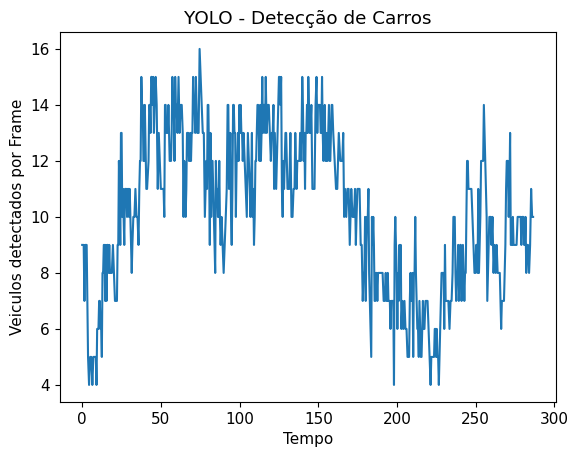

In [ ]:
elapsed_times = [t - timestamps[0] for t in timestamps]
%matplotlib inline
plt.plot(elapsed_times, counts)
plt.xlabel("Tempo")
plt.ylabel("Veiculos detectados por Frame")
plt.title("YOLO - Detecção de Carros")
plt.show()

SSD



---



---



In [ ]:
!pwd

In [ ]:
%cd /content/

In [ ]:
!git clone https://github.com/chuanqi305/MobileNet-SSD/

In [ ]:
!git clone https://github.com/C-Aniruddh/realtime_object_recognition/
%cd realtime_object_recognition
%pip install -r requirements.txt # install dependencies

In [ ]:
PROTOTXT = "/content/MobileNet-SSD/voc/MobileNetSSD_deploy.prototxt"
MODEL = "/content/realtime_object_recognition/MobileNetSSD_deploy.caffemodel"
INP_VIDEO_PATH = '/content/bridge.mp4'
OUT_VIDEO_PATH = '/content/output_ssd-mobileNET.mp4'
GPU_SUPPORT = 0
CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus",  "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

In [ ]:
net = cv2.dnn.readNetFromCaffe(PROTOTXT, MODEL)
if GPU_SUPPORT:
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

detection_counts = []
frame_count = 0

cap = cv2.VideoCapture(INP_VIDEO_PATH)    
w = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter(OUT_VIDEO_PATH, fourcc, 24, (w, h))

while True:
    ret, frame = cap.read()
    if not ret:
      break
    h, w = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 0.007843, (300, 300), 127.5)
    net.setInput(blob)
    detections = net.forward()
    detection_count = 0  # Counter for the current frame's detections
    for i in np.arange(0, detections.shape[2]):
      confidence = detections[0, 0, i, 2]
      if confidence > 0.5:
        detection_count += 1
        idx = int(detections[0, 0, i, 1])
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        label = "{}: {:.2f}%".format(CLASSES[idx],confidence*100)
        cv2.rectangle(frame, (startX, startY), (endX, endY),    COLORS[idx], 2)
        y = startY - 15 if startY - 15 > 15 else startY + 15
        cv2.putText(frame, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)
    detection_counts.append(detection_count)  # Store the detection count for the current frame
    out.write(frame)
    frame_count += 1
out.release()

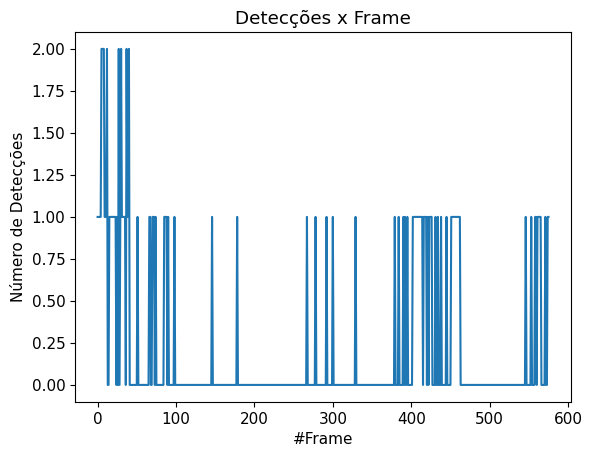

In [ ]:
frame_numbers = range(frame_count)
plt.plot(frame_numbers, detection_counts)
plt.xlabel('#Frame')
plt.ylabel('Número de Detecções')
plt.title('Detecções x Frame')
plt.show()